# VGG16 With Frozen Convolutional Layers

In [3]:
import torch
import matplotlib.pyplot as plt
import os
import time
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Parameters
num_classes = 2  # 2 classes
batch_size = 16
num_epochs = 10
learning_rate = 0.001

# Data transformation for training and testing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Data transformation for the test dataset (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load training and testing datasets
dataset_dir = 'Dataset'

# Load datasets from train and test directories
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=data_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=test_transforms)

# DataLoader for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load VGG16 model and modify final layer
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze convolutional layers

# Update the classifier's final layer to match the number of classes
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=learning_rate)

# Initialize lists to store loss values
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Start timer for total training time
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

# End timer and calculate total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Testing phase
model.eval()
test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

# Save the model
model_path = 'vgg16_trained_model_wfreeze.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")






Epoch 1/10
----------
Train Loss: 0.3730 Acc: 0.8063
Epoch 2/10
----------
Train Loss: 0.0718 Acc: 0.9688
Epoch 3/10
----------
Train Loss: 0.0295 Acc: 0.9938
Epoch 4/10
----------
Train Loss: 0.0146 Acc: 1.0000
Epoch 5/10
----------
Train Loss: 0.0131 Acc: 1.0000
Epoch 6/10
----------
Train Loss: 0.0138 Acc: 0.9938
Epoch 7/10
----------
Train Loss: 0.0145 Acc: 0.9938
Epoch 8/10
----------
Train Loss: 0.0081 Acc: 1.0000
Epoch 9/10
----------
Train Loss: 0.0066 Acc: 1.0000
Epoch 10/10
----------
Train Loss: 0.0060 Acc: 1.0000
Total Training Time: 283.16 seconds
Test Loss: 0.1905 Acc: 0.9500
Model saved to vgg16_trained_model_wfreeze.pth


In [4]:
# Calculate the total parameters of the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 134268738


In [5]:
# Calulate total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")

Total trainable parameters: 8194


c:\Users\abhay\anaconda3\envs\yolov5-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\abhay\AppData\Local\Temp\ipykernel_9516\1958376990.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

Image: 1.jpeg, Predicted Class: honeybee


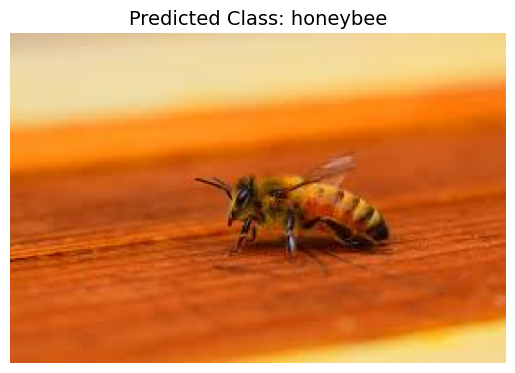

Image: 10.jpeg, Predicted Class: honeybee


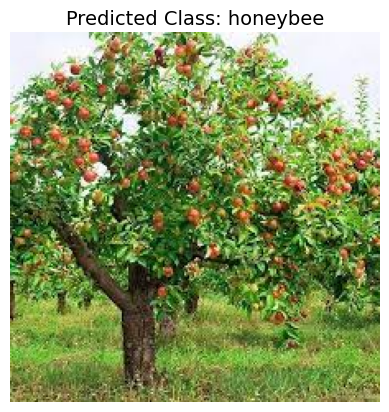

Image: 11.jpeg, Predicted Class: apple


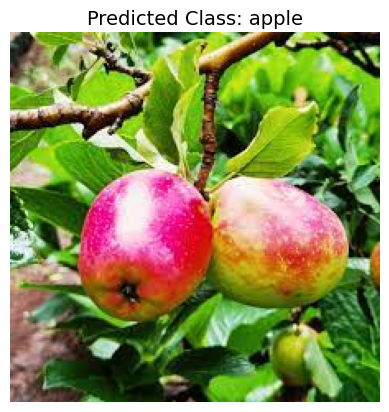

Image: 12.jpeg, Predicted Class: honeybee


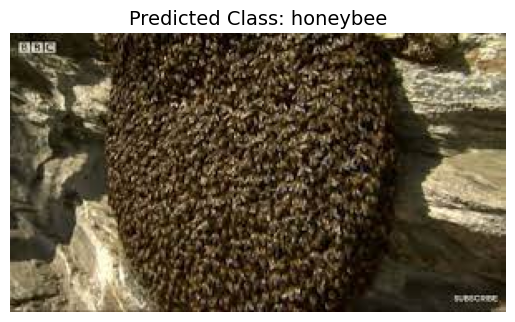

Image: 13.jpeg, Predicted Class: honeybee


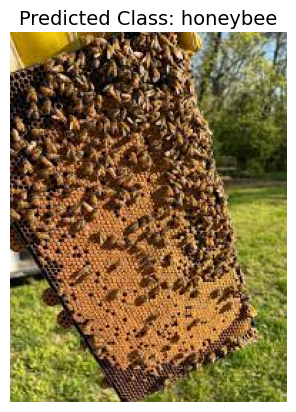

Image: 2.jpeg, Predicted Class: honeybee


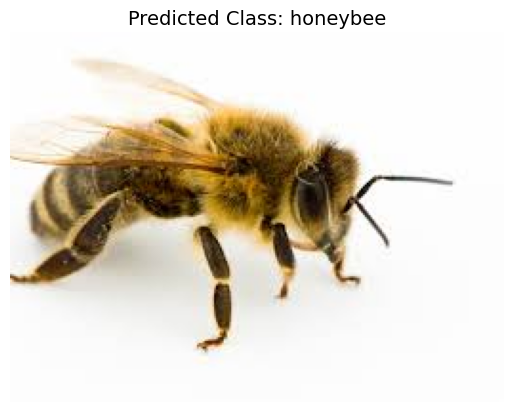

Image: 3.jpeg, Predicted Class: honeybee


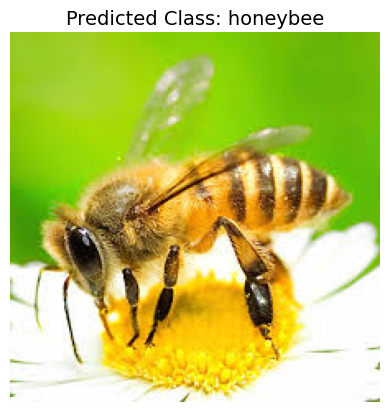

Image: 4.jpeg, Predicted Class: honeybee


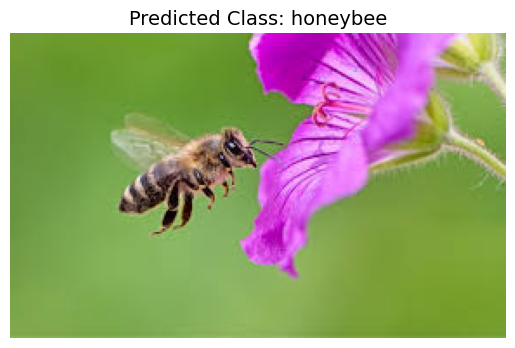

Image: 5.jpeg, Predicted Class: apple


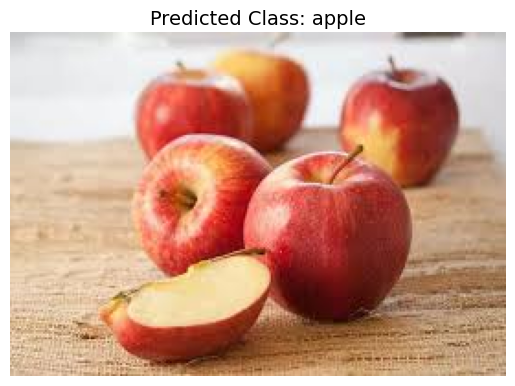

Image: 6.jpeg, Predicted Class: apple


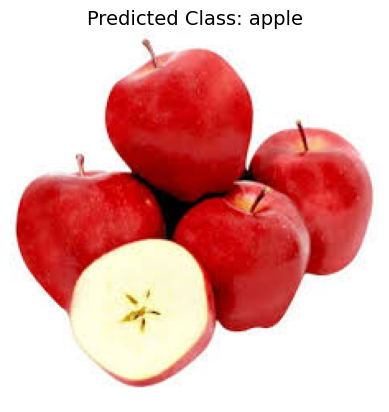

Image: 7.jpeg, Predicted Class: apple


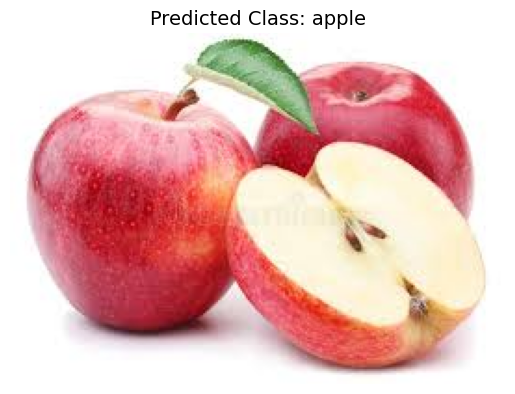

Image: 8.jpeg, Predicted Class: apple


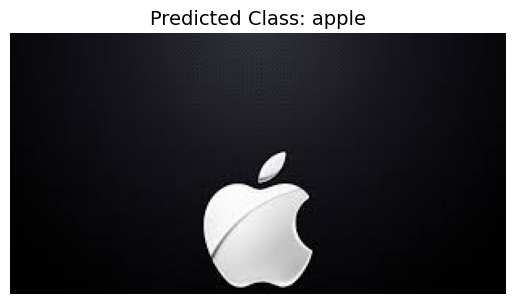

Image: 9.jpeg, Predicted Class: apple


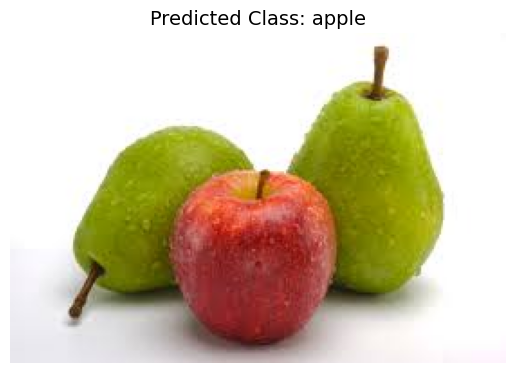

In [17]:
import torch
from torchvision import transforms, models
from PIL import Image
import os
import matplotlib.pyplot as plt

# Path to your trained model
model_path = 'vgg16_trained_model.pth'

# Load the model
model = models.vgg16(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, 2)  # Assuming 2 classes
model.load_state_dict(torch.load(model_path))
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Define image transformation for testing
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Function to predict class of a single image
def predict_image(image_path):
    image = Image.open(image_path)
    image_transformed = test_transforms(image).unsqueeze(0).to(device)  # Apply transformation and add batch dimension

    # Forward pass
    with torch.no_grad():
        output = model(image_transformed)
        _, preds = torch.max(output, 1)  # Get the class with the highest score
    return preds.item()

# Function to display the image with the predicted class
def display_image_with_prediction(image_path, predicted_class):
    image = Image.open(image_path)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f'Predicted Class: {predicted_class}', fontsize=14)
    plt.show()

# Test with images from the test folder or custom images
test_image_dir = 'testing_imgs'  # Directory containing test images
test_images = os.listdir(test_image_dir)

for image_name in test_images:
    image_path = os.path.join(test_image_dir, image_name)
    predicted_class = predict_image(image_path)
    
    # Map class index to class name (optional, if you have class names)
    # For example, if classes are 0 and 1:
    class_names = ['apple', 'honeybee']
    predicted_class_name = class_names[predicted_class]
    
    print(f"Image: {image_name}, Predicted Class: {predicted_class_name}")
    
    # Display the image with predicted class label
    display_image_with_prediction(image_path, predicted_class_name)
